# Deep Q-Network (DQN) on LunarLander-v2

> In this post, We will take a hands-on-lab of Simple Deep Q-Network (DQN) on openAI LunarLander-v2 environment. This is the coding exercise from udacity Deep Reinforcement Learning Nanodegree.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Reinforcement_Learning, PyTorch, Udacity]
- image: images/LunarLander-v2.gif

## Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### Import the Necessary Packages

In [116]:
# !pip install gym[box2d] 

In [117]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

### Instantiate the Environment and Agent

Initialize the environment.

In [118]:
import lunar_lander

# env = gym.make('LunarLander-v2')
env = lunar_lander.LunarLander()
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


e:\RL\gym\venv\lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Define Neural Network Architecture.

Since `LunarLander-v2` environment is sort of simple envs, we don't need complicated architecture. We just need non-linear function approximator that maps from state to action.

In [119]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

### Define some hyperparameter

In [120]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define Agent 

In [122]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Define Replay Buffer

In [123]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Training Process

In [124]:
def dqn(n_episodes=4000, max_t=800, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        if i_episode > 3700:
            eps_end=0.00001
            eps_decay = 0.1
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=180.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -162.03
Episode 200	Average Score: -99.571
Episode 300	Average Score: -122.28
Episode 400	Average Score: -65.850
Episode 500	Average Score: -51.16
Episode 600	Average Score: 46.168
Episode 700	Average Score: 70.18
Episode 800	Average Score: 81.71
Episode 900	Average Score: 129.63
Episode 1000	Average Score: 89.57
Episode 1100	Average Score: 120.66
Episode 1200	Average Score: 111.37
Episode 1300	Average Score: 136.65
Episode 1376	Average Score: 181.31
Environment solved in 1276 episodes!	Average Score: 181.31


### Plot the learning progress

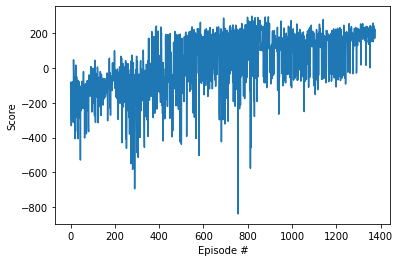

In [125]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [174]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = lunar_lander.LunarLander()
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    for _ in range(1):
        state = env.reset()
        done = False
        i =0
        while not done:
            frame = env.render(mode='rgb_array')
            plt.imshow(frame)
            vid.capture_frame()
            
            action = agent.act(state)

            state, reward, done, _, _ = env.step(action)        
            i = i+1
            if i%100 ==0:
                print('step', i)
    env.close()

In [175]:
from gym.utils.step_api_compatibility import step_api_compatibility


def demo_heuristic_lander(env, seed=None, render=False):

    total_reward = 0
    steps = 0
    s = env.reset(seed=seed)
    while True:
        # a = heuristic(env, s)
        a = agent.act(s)
        s, r, terminated, truncated, info = step_api_compatibility(env.step(a), True)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or terminated or truncated:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if terminated or truncated:
            break
    if render:
        env.close()
    return total_reward

In [176]:
demo_heuristic_lander(lunar_lander.LunarLander(), render=True)

observations: -0.00 +1.42 -0.17 +0.16 +0.00 +0.04 +0.00 +0.00
step 0 total_reward +1.32
observations: -0.04 +1.36 -0.17 -0.38 +0.04 +0.04 +0.00 +0.00
step 20 total_reward -15.26
observations: -0.07 +1.22 -0.18 -0.18 +0.06 +0.02 +0.00 +0.00
step 40 total_reward +7.00
observations: -0.12 +1.16 -0.30 -0.09 +0.06 -0.03 +0.00 +0.00
step 60 total_reward +3.95
observations: -0.18 +1.11 -0.32 -0.10 +0.04 -0.01 +0.00 +0.00
step 80 total_reward +3.95
observations: -0.25 +1.05 -0.35 -0.09 +0.02 -0.01 +0.00 +0.00
step 100 total_reward +4.15
observations: -0.32 +1.01 -0.33 -0.08 -0.03 -0.09 +0.00 +0.00
step 120 total_reward +4.59
observations: -0.37 +0.97 -0.21 -0.04 -0.07 -0.04 +0.00 +0.00
step 140 total_reward +11.03
observations: -0.42 +0.95 -0.23 -0.06 -0.08 -0.02 +0.00 +0.00
step 160 total_reward +4.03
observations: -0.46 +0.93 -0.13 -0.04 -0.07 +0.07 +0.00 +0.00
step 180 total_reward +11.52
observations: -0.48 +0.92 -0.12 -0.01 -0.06 +0.01 +0.00 +0.00
step 200 total_reward +9.57
observations:

106.94739089771902

In [177]:
# agent = Agent(state_size=8, action_size=4, seed=0)
# show_video_of_model(agent, 'LunarLander-v2')

In [178]:
# show_video('LunarLander-v2')